# Import needed libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.stats import skew


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RandomizedLasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.decomposition import PCA

from sklearn.feature_selection import RFECV, RFE, f_regression


from sklearn.decomposition import PCA

%matplotlib inline

# Methods used

In [2]:
# Remove correlated columns as this has a big impact on regression
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

# Load and split the data

In [3]:
user = pd.read_csv("analysis_data.csv", sep=",", index_col="Client")
print(user.shape)

(1566, 41)


In [4]:
user_tr = user[user['Sale_MF']==1]
print(user_tr.shape)

(190, 41)


In [5]:
user_tr = user_tr.drop(['Sale_MF','Sale_CC','Sale_CL','Revenue_CL','Revenue_CC'], axis=1)

In [6]:
print(user_tr.columns)

Index(['Age', 'Tenure', 'M', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA',
       'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Revenue_MF', 'Actbal_CA_avg',
       'ActBal_SA_avg', 'ActBal_MF_avg', 'ActBal_OVD_avg', 'ActBal_CC_avg',
       'ActBal_CL_avg'],
      dtype='object')


Outliers are removed from the dataset

In [7]:
user_tr = user_tr.loc[user_tr['Revenue_MF']<30 ]

In [8]:
user_tr_X = user_tr.drop('Revenue_MF', axis=1)
user_tr_Y = user_tr['Revenue_MF']

Highly correlated datasets are removed from the dataset

In [9]:
user_tr_X= correlation(user_tr_X,0.7)

In [10]:
print(user_tr_X.columns)

Index(['Age', 'Tenure', 'M', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'TransactionsCred', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder'],
      dtype='object')


In [11]:
user_tr_Y.shape

(175,)

## Correlation

In [12]:
for col in user_tr_X.columns:
    print(col)
    print(np.corrcoef(user_tr_Y,user_tr_X[col])[0][1])

Age
-0.0786039489704
Tenure
-0.0167603490729
M
0.0140040626343
Count_CA
0.0221160653089
Count_SA
0.0916907473602
Count_MF
-0.0434096149773
Count_OVD
0.0434791912342
Count_CC
0.020500851189
Count_CL
0.0453796399019
ActBal_CA
0.0332643970884
ActBal_SA
-0.000620062542971
ActBal_MF
-0.0341095170972
ActBal_OVD
-0.0414427246181
ActBal_CC
-0.0313821685996
ActBal_CL
0.0901113591294
VolumeCred
-0.0831182637605
TransactionsCred
-0.00355182461549
VolumeDebCash_Card
-0.0112486486249
VolumeDebCashless_Card
-0.0703551883497
TransactionsDebCash_Card
-0.107024880148
TransactionsDeb_PaymentOrder
-0.0403609622989


As seen no real correlation exist between the target and one of the remaining variables

# Preprocessing

## Check target variable

In [13]:
user_tr_Y.describe()

count    175.000000
mean       5.205441
std        6.384083
min        0.004821
25%        1.078304
50%        2.701071
75%        6.738482
max       28.295536
Name: Revenue_MF, dtype: float64

In [14]:
user_tr_Y.sort_values(ascending = False).head(10)

Client
129     28.295536
1399    27.233750
1       26.972679
1484    25.609107
372     24.545893
673     24.135893
1469    22.742500
1206    22.165893
477     22.098214
1500    21.025000
Name: Revenue_MF, dtype: float64

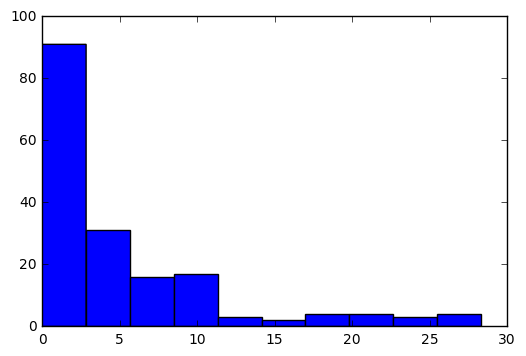

In [15]:
plt.hist(user_tr_Y)
plt.show()

The target will be log transformed for better regression

In [16]:
user_tr_Y = np.log1p(user_tr_Y)
user_tr_X.replace(np.NaN, 0, inplace=True)

# Choose model

In [17]:
reg = BayesianRidge()
scores = cross_val_score(reg, user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

neg_mean_squared_error: -0.94 (+/- 0.54)
[-0.96837115 -0.71690551 -1.29573945 -0.57926401 -0.64342171 -0.97333511
 -1.19534013 -0.91993257 -1.39375001 -0.7115705 ]


In [18]:
reg = Ridge()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.45 (+/- 2.54)


In [19]:
reg = RandomForestRegressor()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.90 (+/- 0.26)


In [20]:
reg = LinearRegression()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.46 (+/- 2.53)


## Scaling the params for support vector algo

In [21]:
#Scale the 
user_tr_X_scale = scale(user_tr_X)
user_tr_Y_scale = scale(user_tr_Y)

In [22]:
svr = SVR(kernel='linear')
scores = cross_val_score(svr,user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.84 (+/- 2.52)


In [23]:
svr = SVR(kernel='rbf')
scores = cross_val_score(svr,user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.22 (+/- 0.62)


In [24]:
reg = Lasso()
scores = cross_val_score(reg, user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.02 (+/- 0.44)


In [25]:
reg = KNeighborsRegressor()
scores = cross_val_score(reg,user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.31 (+/- 0.57)


## check if improvements with polynomial features

In [26]:
poly = PolynomialFeatures(degree=2)
user_tr_X_pol = poly.fit_transform(user_tr_X)

In [27]:
reg = Lasso(tol = 0.5)
scores = cross_val_score(reg, user_tr_X_pol, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -6.68 (+/- 21.09)


# PCA

Maybe some PCA will improve it but probably not as Lasso already removes the unnecessary variables by regularization

In [28]:
#dimension reduction
pca = PCA(n_components=10)
X_pca_20 = pca.fit_transform(user_tr_X)
X_pca_20.shape

(175, 10)

In [29]:
reg = Lasso(tol=10)
scores = cross_val_score(reg, X_pca_20, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.97 (+/- 0.57)


# Result

# The Lasso algo is the best and we will use it for prediction

# Optimization of the algorithm

In [30]:
search = { 'alpha':[0.001,0.1,0.5, 0.7, 1], 'tol':[0.01,0.5, 1,5,10]}


lasso = Lasso()

lasso_grid = GridSearchCV(estimator=lasso,param_grid=search, scoring='neg_mean_squared_error', n_jobs=-1,refit=True, cv=10)

lasso_grid.fit( user_tr_X, user_tr_Y)

print(lasso_grid.best_estimator_)

print(lasso_grid.best_params_)

print(lasso_grid.best_score_)

Lasso(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=5, warm_start=False)
{'alpha': 0.7, 'tol': 5}
-0.940031668356


Let's have a quick look at the residuals of the estimator. 
These should follow a random pattern.

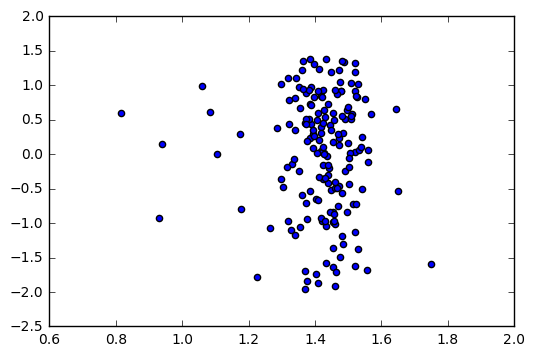

In [31]:
plt.scatter(lasso_grid.predict(user_tr_X), lasso_grid.predict(user_tr_X)-user_tr_Y)

Looks pretty random :)

# Fit the model and predict the missing values

In [32]:
user_pred = pd.read_csv("mutual_fund_prop_pred.csv", sep=",", index_col="Client")
print(user_pred.shape)

(629, 36)


In [33]:
user_pred_X = user_pred.ix[(user_pred['Sale_MF_pred']==1)]
user_pred_X = user_pred_X.drop('Sale_MF_pred', axis=1)


In [34]:
#user_pred_X[skewed_feats] = np.log1p(user_pred_X[skewed_feats])

In [35]:
user_pred_X.head()

,Age,Tenure,M,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Actbal_CA_avg,ActBal_SA_avg,ActBal_MF_avg,ActBal_OVD_avg,ActBal_CC_avg,ActBal_CL_avg
Client,,,,,,,,,,,,,,,,,,,,,
267,73.0,36,0.0,1,0.0,0.0,0.0,0.0,0.0,0.000000,...,12,1,7,2,0.000000,0.0,0.000000,0.0,0.000000,0.000000
64,61.0,38,0.0,1,0.0,0.0,1.0,0.0,0.0,0.759643,...,51,3,42,4,0.759643,0.0,0.000000,0.0,0.000000,0.000000
1614,48.0,65,1.0,1,0.0,0.0,0.0,0.0,0.0,0.010357,...,15,1,8,3,0.010357,0.0,0.000000,0.0,0.000000,0.000000
456,66.0,18,1.0,1,0.0,4.0,0.0,0.0,0.0,0.000000,...,20,1,11,8,0.000000,0.0,21647.442768,0.0,0.000000,0.000000
100,39.0,86,0.0,1,0.0,0.0,0.0,1.0,1.0,0.000000,...,13,1,17,8,0.000000,0.0,0.000000,0.0,247.493214,802.807143


In [36]:
user_pred_Y = np.expm1(lasso_grid.predict(user_pred_X[user_tr_X.columns]))

In [37]:
user_pred_Y

array([ 2.69341826,  2.89179351,  3.08448372,  2.55522836,  3.27775294,
        3.30162145,  2.74463785,  3.12006689,  3.28152967,  3.128789  ,
        3.26955416,  3.49089621,  3.41042604,  3.26726968,  2.89971491,
        2.95965673,  3.39694292,  3.28350444,  3.40964281,  3.54187103,
        3.58182195,  2.97162426,  3.43858896,  2.11339832,  2.86826715,
        3.58660898,  3.18233691])

In [38]:
user_pred = user_pred.ix[(user_pred['Sale_MF_pred']==1)]
user_pred['Sale_MF_pred_value'] = pd.Series(user_pred_Y,index=user_pred.index)

In [39]:
user_pred['Sale_MF_pred_value'].shape

(27,)

In [40]:
user_pred['Sale_MF_pred_value'].describe()

count    27.000000
mean      3.138942
std       0.345857
min       2.113398
25%       2.929686
50%       3.267270
75%       3.403293
max       3.586609
Name: Sale_MF_pred_value, dtype: float64

In [41]:
user_pred.to_csv(path_or_buf='mutual_fund_prop_pred_value.csv')